<a href="https://colab.research.google.com/github/JustinPMaio/RoboticSwarmSimulation/blob/main/Justin_Maio_%26_Dan_Morasco_assignment_2_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace
import numpy as np
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torchvision.transforms as transforms
import random
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = 16, 12

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-1xvroed_
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-1xvroed_


In [10]:
# warming up
# automatic differentiation
x = torch.ones(1, requires_grad=True)

y = x**2 + 5 

z = 4 * y * y 

print(x, y, z)

# lets calculate dz/dx = dz/dy * dy/dx
# dz / dy = 8 * y
# dy / dx = 2 * x
# dz / dx = 16 * x * y

# using automatic differentiation
# calculates all the required partial derivatives 
z.backward()
print(x.grad)

tensor([1.], requires_grad=True) tensor([6.], grad_fn=<AddBackward0>) tensor([144.], grad_fn=<MulBackward0>)
tensor([96.])


In [11]:
class MLP(torch.nn.Module):

    def __init__(self):
        # must call base constructor
        super(MLP, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(64, 25)
        self.fc2 = nn.Linear(25, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 10)

    def forward(self, x):        
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = func.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [12]:
class DigitsDataset(Dataset):

    def __init__(self, x, y):
        # you can normalize if you want
        self.x = torch.from_numpy(x).float()
        #self.x = func.normalize(self.x, p=1, dim=0)
        
        # no need for one-hot encoding
        # every y is a scalar in the [0,C-1] interval
        self.y = torch.from_numpy(y)

        # save the number of examples
        self.n_samples = x.shape[0]

    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

    def __len__(self):
        return self.n_samples


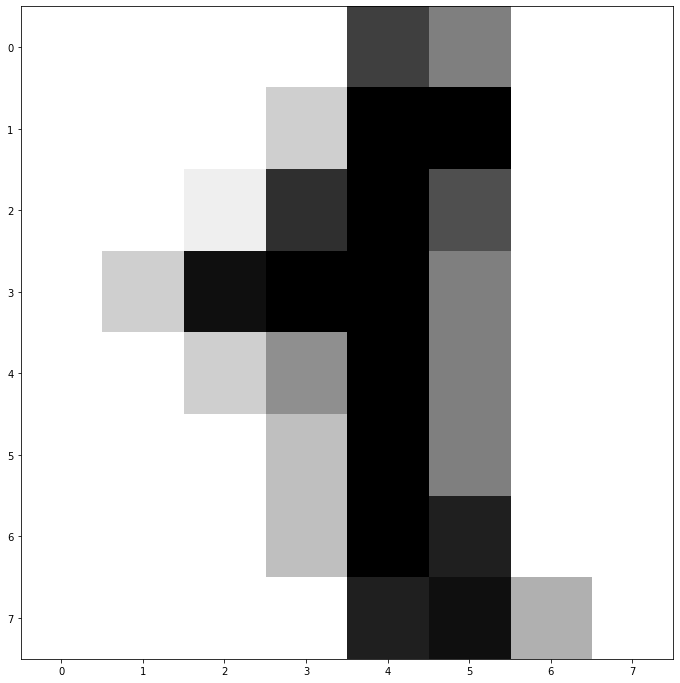

In [13]:
digits = load_digits()
idx = random.randrange(digits.data.shape[0])
plt.imshow(digits.data[idx].reshape(8,8), cmap=plt.cm.gray_r)

In [24]:
train_dataset = DigitsDataset(digits.data, digits.target)
split_dataset = random_split(train_dataset, [round(0.7*len(train_dataset)), round(0.3*len(train_dataset))], generator=torch.Generator().manual_seed(42))
(train_dataset, val_dataset) = split_dataset
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=True, num_workers=4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


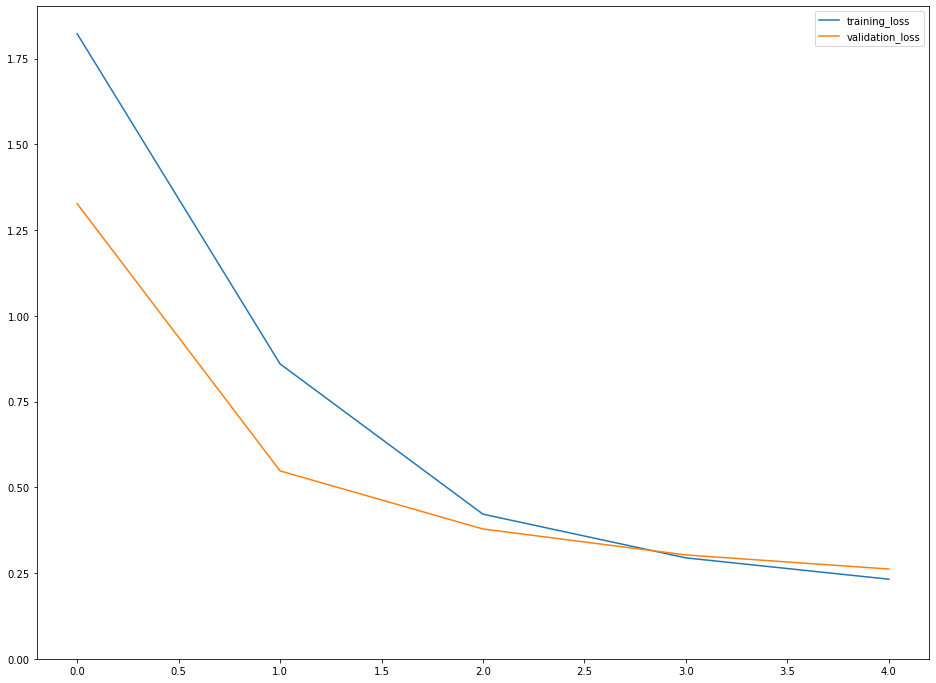

In [26]:
print(len(train_dataset))
print(len(val_dataset))
n_epochs = 5
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

# an epoch is one pass over the entire training set
training_losses = []
validation_losses = []
for epoch in range(n_epochs):
    tr_epoch_loss = 0
    val_epoch_loss = 0
    model.train() # can also use model.eval() for inference
    for nn_x, nn_y in train_dataloader:
        optimizer.zero_grad()
        pred = model(nn_x) # forward pass of an entire batch
        training_loss = criterion(pred, nn_y)
        training_loss.backward() # gradient calculation
        tr_epoch_loss += training_loss.item()
        optimizer.step() # gradient step -- update weights
    for nn_x, nn_y in val_dataloader:
        pred = model(nn_x) # forward pass of an entire batch
        validation_loss = criterion(pred, nn_y)
        val_epoch_loss += validation_loss.item()
    training_losses.append(tr_epoch_loss / len(train_dataset))
    validation_losses.append(val_epoch_loss / len(val_dataset))
plt.plot(training_losses, label = "training_loss")
plt.plot(validation_losses, label = "validation_loss")
plt.ylim(bottom=0)
plt.legend()
display.display(plt.gcf())
display.clear_output(wait=True)
#print('Epoch: {}   Training_Loss: {}'.format(epoch+1, tr_epoch_loss/len(train_dataset)) 'Validation_Loss: {}'.format(epoch+1, val_epoch_loss/len(val_dataset)))

Epoch: 500   Training Loss: 9.972873708453556e-05
Epoch: 500   Validation Loss: 0.22926693977920606


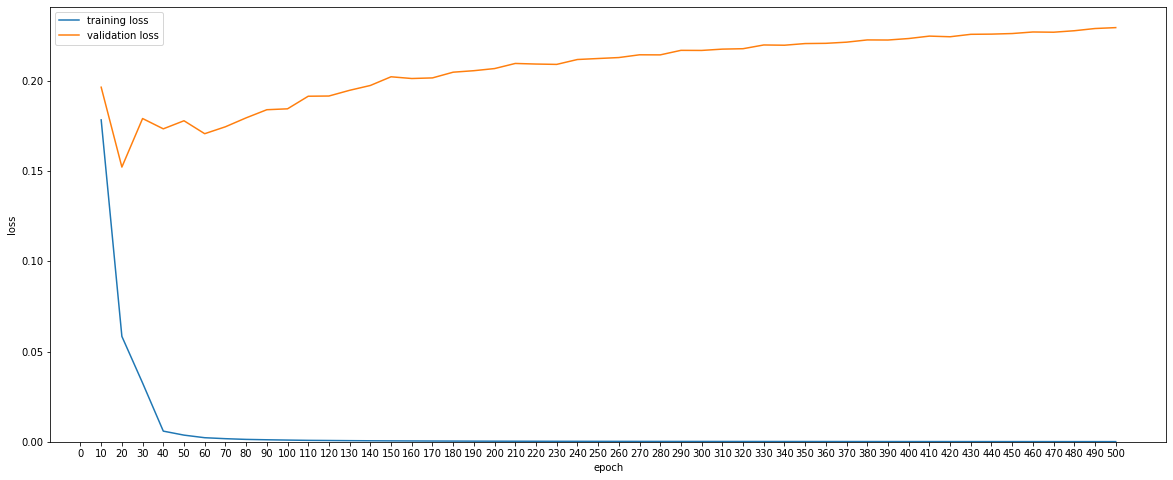

In [28]:
# Train model with SGD
print(len(train_dataset))
n_epochs = 500
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

# an epoch is one pass over the entire training set
every_tenth_tr_epoch_loss = []
every_tenth_val_epoch_loss = []

every_tenth_x = []
i = 1
for epoch in range(n_epochs):
    i += 1
    tr_epoch_loss = 0
    val_epoch_loss = 0
    model.train() # can also use model.eval() for inference
    for nn_x, nn_y in train_dataloader:
        optimizer.zero_grad()
        pred = model(nn_x) # forward pass of an entire batch
        training_loss = criterion(pred, nn_y)
        training_loss.backward() # gradient calculation
        tr_epoch_loss += training_loss.item()
        optimizer.step() # gradient step -- update weights
    for nn_x, nn_y in val_dataloader:
        pred = model(nn_x) # forward pass of an entire batch
        validation_loss = criterion(pred, nn_y)
        val_epoch_loss += validation_loss.item()
    if i%10 == 0:
      every_tenth_tr_epoch_loss.append(tr_epoch_loss / len(train_dataset))
      every_tenth_val_epoch_loss.append(val_epoch_loss / len(val_dataset))
      every_tenth_x.append(i)
      print(i)
plt.xticks(np.arange(0, 501, 10))
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(every_tenth_x, every_tenth_tr_epoch_loss, label="training loss")
plt.plot(every_tenth_x, every_tenth_val_epoch_loss, label="validation loss")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
display.display(plt.gcf())
display.clear_output(wait=True)
print('Epoch: {}   Training Loss: {}'.format(epoch+1, tr_epoch_loss/len(train_dataset)))
print('Epoch: {}   Validation Loss: {}'.format(epoch+1, val_epoch_loss/len(val_dataset)))

Epoch: 500   Training Loss: 3.2975604174294418e-06
Epoch: 500   Validation Loss: 7.672779649109035e-06


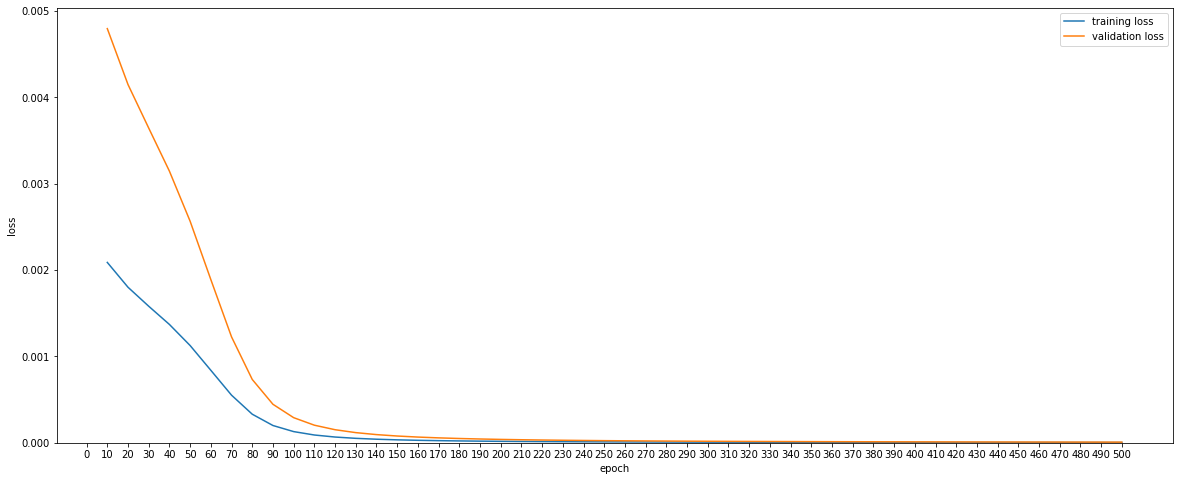

In [30]:
# Train model with batch
print(len(train_dataset))
n_epochs = 500
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

# an epoch is one pass over the entire training set
every_tenth_tr_epoch_loss = []
every_tenth_val_epoch_loss = []
every_tenth_x = []
i = 1
for epoch in range(n_epochs):
    i += 1
    tr_epoch_loss = 0
    val_epoch_loss = 0
    model.train() # can also use model.eval() for inference
    optimizer.zero_grad()
    pred = model(nn_x) # forward pass of an entire batch
    training_loss = criterion(pred, nn_y)
    training_loss.backward() # gradient calculation
    tr_epoch_loss += training_loss.item()
    optimizer.step() # gradient step -- update weights
    pred_val = model(nn_x) # forward pass of an entire batch
    validation_loss = criterion(pred_val, nn_y)
    val_epoch_loss += validation_loss.item()
    if i%10 == 0:
      every_tenth_tr_epoch_loss.append(tr_epoch_loss / len(train_dataset))
      every_tenth_val_epoch_loss.append(val_epoch_loss / len(val_dataset))
      every_tenth_x.append(i)
      print(i)
plt.xticks(np.arange(0, 501, 10))
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(every_tenth_x, every_tenth_tr_epoch_loss, label="training loss")
plt.plot(every_tenth_x, every_tenth_val_epoch_loss, label="validation loss")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
display.display(plt.gcf())
display.clear_output(wait=True)
print('Epoch: {}   Training Loss: {}'.format(epoch+1, tr_epoch_loss/len(train_dataset)))
print('Epoch: {}   Validation Loss: {}'.format(epoch+1, val_epoch_loss/len(val_dataset)))

Epoch: 500   Training Loss: 9.978756341822288e-05
Epoch: 500   Validation Loss: 0.13597953125682413


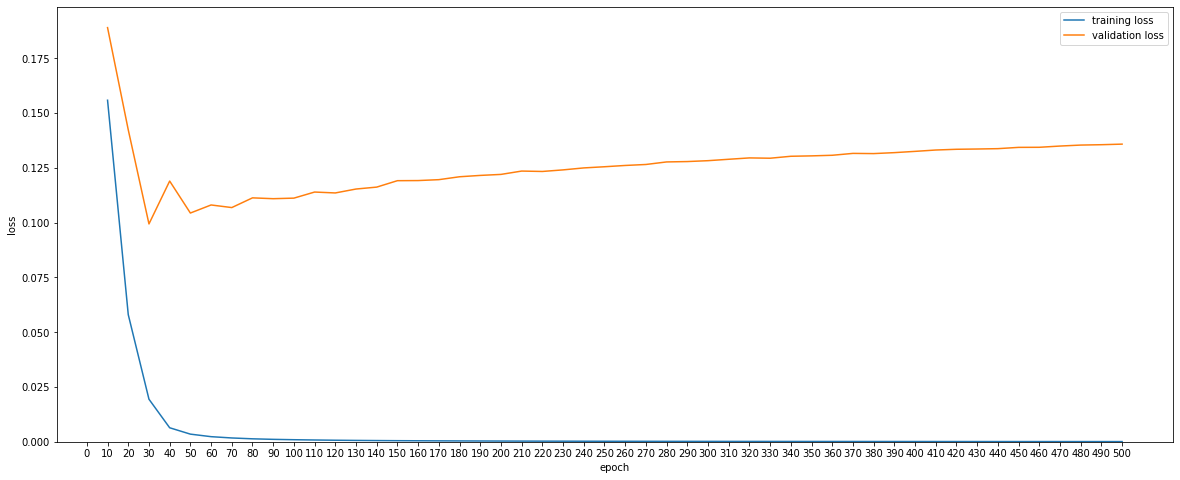

In [31]:
# Train model with mini-batch size 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))
n_epochs = 500
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

# an epoch is one pass over the entire training set
every_tenth_tr_epoch_loss = []
every_tenth_val_epoch_loss = []

every_tenth_x = []
i = 1
for epoch in range(n_epochs):
    i += 1
    tr_epoch_loss = 0
    val_epoch_loss = 0
    model.train() # can also use model.eval() for inference
    for nn_x, nn_y in train_dataloader:
        optimizer.zero_grad()
        pred = model(nn_x) # forward pass of an entire batch
        training_loss = criterion(pred, nn_y)
        training_loss.backward() # gradient calculation
        tr_epoch_loss += training_loss.item()
        optimizer.step() # gradient step -- update weights
    for nn_x, nn_y in val_dataloader:
        pred = model(nn_x) # forward pass of an entire batch
        validation_loss = criterion(pred, nn_y)
        val_epoch_loss += validation_loss.item()
    if i%10 == 0:
      every_tenth_tr_epoch_loss.append(tr_epoch_loss / len(train_dataset))
      every_tenth_val_epoch_loss.append(val_epoch_loss / len(val_dataset))
      every_tenth_x.append(i)
      print(i)
plt.xticks(np.arange(0, 501, 10))
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(every_tenth_x, every_tenth_tr_epoch_loss, label="training loss")
plt.plot(every_tenth_x, every_tenth_val_epoch_loss, label="validation loss")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
display.display(plt.gcf())
display.clear_output(wait=True)
print('Epoch: {}   Training Loss: {}'.format(epoch+1, tr_epoch_loss/len(train_dataset)))
print('Epoch: {}   Validation Loss: {}'.format(epoch+1, val_epoch_loss/len(val_dataset)))


Epoch: 500   Training Loss: 8.567403768750414e-05
Epoch: 500   Validation Loss: 0.18404037296661419


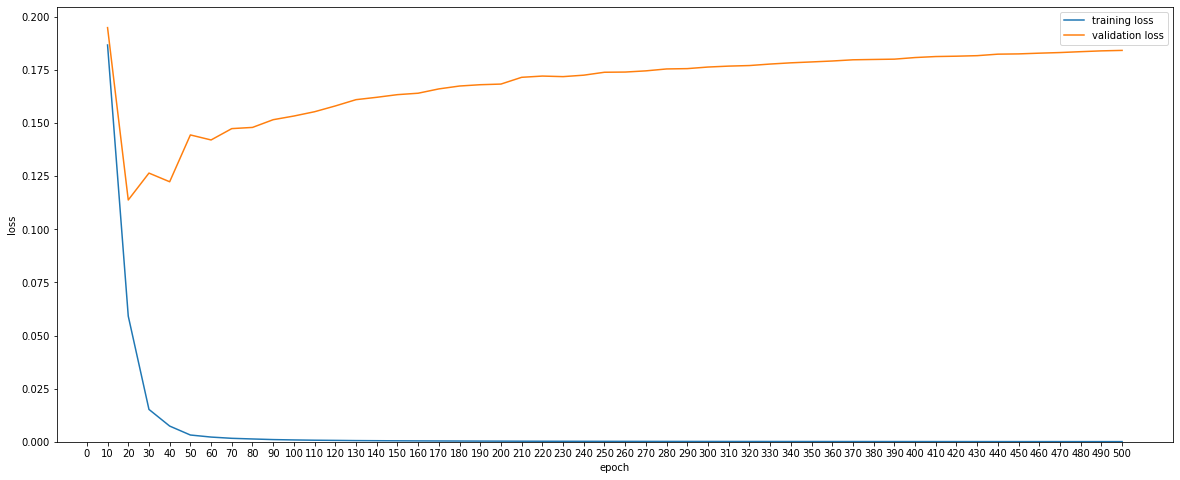

In [32]:
# Train model with mini-batch size 64
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))
n_epochs = 500
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

# an epoch is one pass over the entire training set
every_tenth_tr_epoch_loss = []
every_tenth_val_epoch_loss = []

every_tenth_x = []
i = 1
for epoch in range(n_epochs):
    i += 1
    tr_epoch_loss = 0
    val_epoch_loss = 0
    model.train() # can also use model.eval() for inference
    for nn_x, nn_y in train_dataloader:
        optimizer.zero_grad()
        pred = model(nn_x) # forward pass of an entire batch
        training_loss = criterion(pred, nn_y)
        training_loss.backward() # gradient calculation
        tr_epoch_loss += training_loss.item()
        optimizer.step() # gradient step -- update weights
    for nn_x, nn_y in val_dataloader:
        pred = model(nn_x) # forward pass of an entire batch
        validation_loss = criterion(pred, nn_y)
        val_epoch_loss += validation_loss.item()
    if i%10 == 0:
      every_tenth_tr_epoch_loss.append(tr_epoch_loss / len(train_dataset))
      every_tenth_val_epoch_loss.append(val_epoch_loss / len(val_dataset))
      every_tenth_x.append(i)
      print(i)
plt.xticks(np.arange(0, 501, 10))
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(every_tenth_x, every_tenth_tr_epoch_loss, label="training loss")
plt.plot(every_tenth_x, every_tenth_val_epoch_loss, label="validation loss")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
display.display(plt.gcf())
display.clear_output(wait=True)
print('Epoch: {}   Training Loss: {}'.format(epoch+1, tr_epoch_loss/len(train_dataset)))
print('Epoch: {}   Validation Loss: {}'.format(epoch+1, val_epoch_loss/len(val_dataset)))

Epoch: 500   Training Loss: 9.427376355034179e-05
Epoch: 500   Validation Loss: 0.19444626005770765


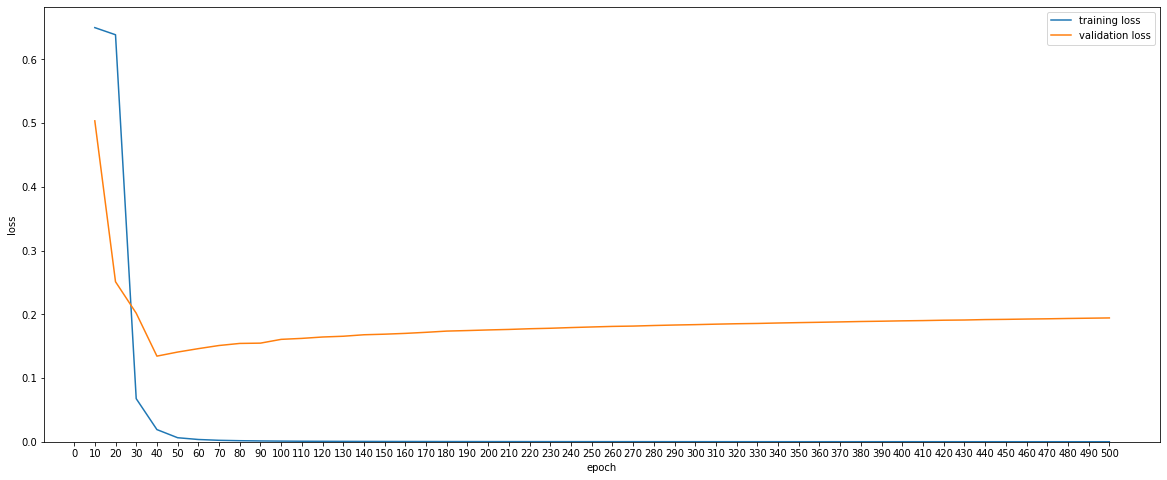

In [33]:
# Train model with mini-batch size 128
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))
n_epochs = 500
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

# an epoch is one pass over the entire training set
every_tenth_tr_epoch_loss = []
every_tenth_val_epoch_loss = []

every_tenth_x = []
i = 1
for epoch in range(n_epochs):
    i += 1
    tr_epoch_loss = 0
    val_epoch_loss = 0
    model.train() # can also use model.eval() for inference
    for nn_x, nn_y in train_dataloader:
        optimizer.zero_grad()
        pred = model(nn_x) # forward pass of an entire batch
        training_loss = criterion(pred, nn_y)
        training_loss.backward() # gradient calculation
        tr_epoch_loss += training_loss.item()
        optimizer.step() # gradient step -- update weights
    for nn_x, nn_y in val_dataloader:
        pred = model(nn_x) # forward pass of an entire batch
        validation_loss = criterion(pred, nn_y)
        val_epoch_loss += validation_loss.item()
    if i%10 == 0:
      every_tenth_tr_epoch_loss.append(tr_epoch_loss / len(train_dataset))
      every_tenth_val_epoch_loss.append(val_epoch_loss / len(val_dataset))
      every_tenth_x.append(i)
      print(i)
plt.xticks(np.arange(0, 501, 10))
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(every_tenth_x, every_tenth_tr_epoch_loss, label="training loss")
plt.plot(every_tenth_x, every_tenth_val_epoch_loss, label="validation loss")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
display.display(plt.gcf())
display.clear_output(wait=True)
print('Epoch: {}   Training Loss: {}'.format(epoch+1, tr_epoch_loss/len(train_dataset)))
print('Epoch: {}   Validation Loss: {}'.format(epoch+1, val_epoch_loss/len(val_dataset)))